In [1]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
fitness_df = pd.read_csv('../Data/fitness_clean.csv', index_col=0)
bodyweight_df = pd.read_csv('../Data/bodyweight_clean.csv', index_col=0)

# Character Count Distributions

In [3]:
fitness_df['char_count'] = fitness_df['selftext'].str.len()
bodyweight_df['char_count'] = bodyweight_df['selftext'].str.len()

In [6]:
fitness_df[['char_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
char_count,6711.0,582.525555,531.846808,69.0,272.5,438.0,708.0,11384.0


In [7]:
bodyweight_df[['char_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
char_count,7052.0,586.659246,736.747156,11.0,239.0,407.0,688.0,17356.0


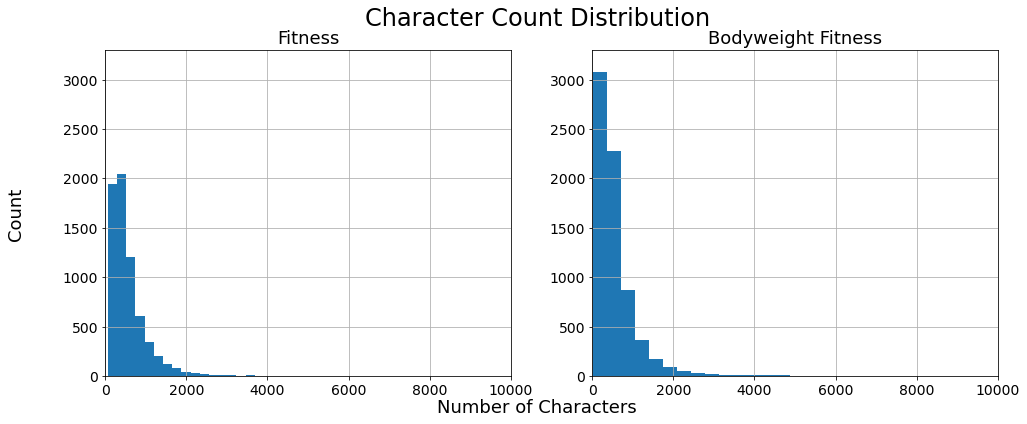

In [58]:
# Plot character count distributions
fig, ax = plt.subplots(1, 2, figsize=(16,6))
fitness_df['char_count'].hist(bins=50, ax=ax[0], 
                              xlabelsize=14, ylabelsize=14)
bodyweight_df['char_count'].hist(bins=50, ax=ax[1],
                                 xlabelsize=14, ylabelsize=14)

ax[0].set_xlim([0, 10_000])
ax[0].set_ylim([0,3300])
ax[0].set_title('Fitness', fontsize=18)
ax[1].set_xlim([0, 10_000])
ax[1].set_ylim([0,3300])
ax[1].set_title('Bodyweight Fitness', fontsize=18)

fig.suptitle('Character Count Distribution', fontsize=24)
fig.text(0.5, 0.04, 'Number of Characters', 
         ha='center', fontsize=18)
fig.text(0.04, 0.5, 'Count', va='center', 
         rotation='vertical', fontsize=18);
plt.savefig('../Presentation/Images/char_count_dist.png')

#### Results
Similar character count distributions show that users tend towards shorter posts in each subreddit.  It is unlikely that the length of post will be helpful in determining which subreddit a post is from.

# Most Frequent Words

In [10]:
# Instantiate count vectorizer
cvect = CountVectorizer(stop_words='english')

In [12]:
# Vectorize fitness posts and create dataframe with words and counts
fitness_vect = cvect.fit_transform(fitness_df['selftext'])
fitness_dtm = pd.DataFrame(fitness_vect.toarray(), columns = cvect.get_feature_names())

In [13]:
# Vectorize bodyweight posts and create dataframe with words and counts
bodyweight_vect = cvect.fit_transform(bodyweight_df['selftext'])
bodyweight_dtm = pd.DataFrame(bodyweight_vect.toarray(), columns = cvect.get_feature_names())

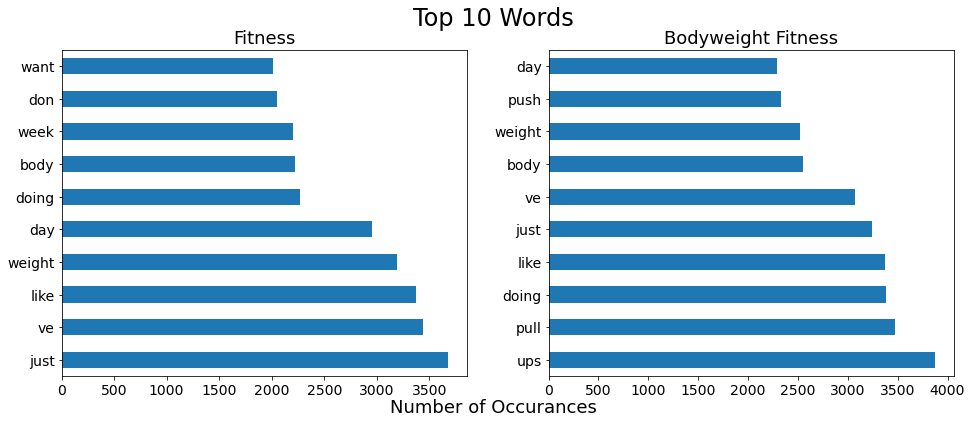

In [24]:
#Plot the Most Frequently Occurring Words

fig, ax = plt.subplots(1, 2, figsize=(16,6))
fitness_dtm.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0], fontsize=14)
bodyweight_dtm.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1], fontsize=14)

ax[0].set_title('Fitness', fontsize=18)
ax[1].set_title('Bodyweight Fitness', fontsize=18)

fig.suptitle('Top 10 Words', fontsize=24)
fig.text(0.5, 0.04, 'Number of Occurances', 
         ha='center', fontsize=18);

#### Results
Seeing some distinguishing words show up for bodyweight fitness such as pull, push, ups.  More occure after the top 10.  Also seeing terms split from contracted words like 've' and 'don'.  I will try to eliminate more with custom preprocessing

# Custom Preprocessing

In [40]:
# using isalnum method to remove special characters from
# https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string

def my_preprocessor(text):
    """Process text for use with vectorizer.
    
    Takes in a string and modifies it for use with count or tf-idf
    vectorizer.  It will set all characters to lowercase, remove and urls,
    remove the apostrophe from contractions, and replace non-alphanumeric
    characters with a space.
    
    Args:
        text (string): string to be processed
    
    Returns:
        string: processed text string
    """
    text = text.lower()
    text = re.sub('http\S+|www.\S+', '', text)
    text = text.replace("'", '')
    text = ''.join(w if w.isalnum() or w == ' ' else ' ' for w in text)
    
    return text

In [41]:
cvect2 = CountVectorizer(
    preprocessor=my_preprocessor,
    stop_words='english'
)

In [42]:
# Vectorize fitness posts and create dataframe with words and counts
fitness_vect2 = cvect2.fit_transform(fitness_df['selftext'])
fitness_dtm2 = pd.DataFrame(fitness_vect2.toarray(), columns = cvect2.get_feature_names())

In [43]:
# Vectorize bodyweight posts and create dataframe with words and counts
bodyweight_vect2 = cvect2.fit_transform(bodyweight_df['selftext'])
bodyweight_dtm2 = pd.DataFrame(bodyweight_vect2.toarray(), columns = cvect2.get_feature_names())

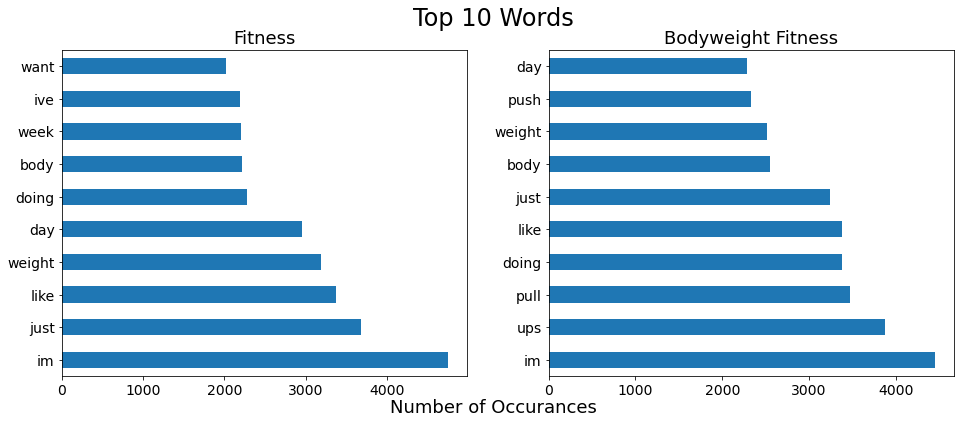

In [44]:
#Plot the Most Frequently Occurring Words

fig, ax = plt.subplots(1, 2, figsize=(16,6))
fitness_dtm2.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0], fontsize=14)
bodyweight_dtm2.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1], fontsize=14)

ax[0].set_title('Fitness', fontsize=18)
ax[1].set_title('Bodyweight Fitness', fontsize=18)

fig.suptitle('Top 10 Words', fontsize=24)
fig.text(0.5, 0.04, 'Number of Occurances', 
         ha='center', fontsize=18);

#### Results
Top 10 words mostly stayed the same, but the contractions are now together.  English stopwords not catching some that I would expect.  On researching this is due to a combination of my custom preprocessing modifying words that would have matched in the list, and English stopwords provided in sklearn not being as robust as desired.

# Using Different Tokenizers

## Lemmetizer

In [45]:
def my_lemmatizer(text):
    wnet = WordNetLemmatizer()
    return [wnet.lemmatize(w) for w in word_tokenize(text)]

In [46]:
def my_stemmer(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in word_tokenize(text)]

In [47]:
# Download stopwords from nltk
# Uncomment line below and run if necessary
#nltk.download('stopwords')

In [50]:
# apply same pre-processing as posts to stopwords
# inspiration from https://stackoverflow.com/questions/50155188/lemmatization-on-countvectorizer-doesnt-remove-stopwords
wnet = WordNetLemmatizer()
lem_stopwords = [wnet.lemmatize(w.replace("'",'')) for w in stopwords.words('english')]

In [52]:
cvect3 = CountVectorizer(
    preprocessor=my_preprocessor,
    tokenizer=my_lemmatizer,
    stop_words=lem_stopwords
)

In [53]:
# Vectorize fitness posts and create dataframe with words and counts
fitness_vect3 = cvect3.fit_transform(fitness_df['selftext'])
fitness_dtm3 = pd.DataFrame(fitness_vect3.toarray(), columns = cvect3.get_feature_names())

In [54]:
3# Vectorize bodyweight posts and create dataframe with words and counts
bodyweight_vect3 = cvect3.fit_transform(bodyweight_df['selftext'])
bodyweight_dtm3 = pd.DataFrame(bodyweight_vect3.toarray(), columns = cvect3.get_feature_names())

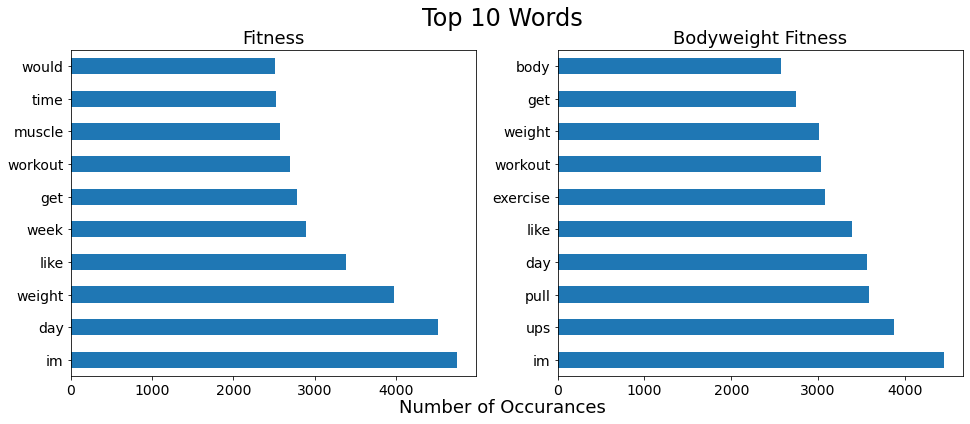

In [57]:
#Plot the Most Frequently Occurring Words

fig, ax = plt.subplots(1, 2, figsize=(16,6))
fitness_dtm3.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0], fontsize=14)
bodyweight_dtm3.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1], fontsize=14)

ax[0].set_title('Fitness', fontsize=18)
ax[1].set_title('Bodyweight Fitness', fontsize=18)

fig.suptitle('Top 10 Words', fontsize=24)
fig.text(0.5, 0.04, 'Number of Occurances', 
         ha='center', fontsize=18);
plt.savefig('../Presentation/Images/top_10_words.png')

### Results
A few more potentialy more helpful related terms show up now.

# Overall EDA Conclusions 
Custom preprocessing with lemmetizing seems to provide the most recognizable top words related to fitness and bodyweight fitness.  This requires that the same processing also be done to the stop words.  However, there are still many general terms towards the top.  Also, there are many specific terms with high frequency that occur in both lists.  This may indicate that it will be a challenge to differentiate between the two subreddits when classifying.